In [1]:
import sys
sys.path.append('../')

import mmgclip
import torch
import torch
import torch.utils.data
import numpy as np

from mmgclip.dataset.datasampler import ImbalancedDatasetSampler

from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from attrdict import AttrDict

torch.cuda.empty_cache() 

# for auto reload when changes are made in the package
%load_ext autoreload
%autoreload 2

/local/abdel/mmg-clip/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/abdel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with initialize(config_path="../configs"):
    cfg = compose(config_name="train_prompt_clf") # train_prompt_clf, train_multi_class_clf

print(OmegaConf.to_yaml(cfg.base))

patience: 5
seed: 42
features_export_dir: outputs/dataset
export_dir: ${hydra:run.dir}
results_export_dir: ${hydra:run.dir}/results
tensorboard_export_dir: runs/${now:%Y-%m-%d}/${now:%H-%M-%S}



In [3]:
# convert the config dict to a class object
try:
    cfg['dataset']['config']['lists_dataset_path'] = "../data/02_data_lists/data/lists"
    cfg['dataset']['config']['annotated_dataset_path'] = "../data/02_data_T_regions"
    cfg['base']['features_export_dir'] = "../outputs/dataset"
    cfg['base']['export_dir'] = '../outputs/2024-05-23/12-44-19'
    cfg['base']['results_export_dir'] = '../outputs/2024-05-23/12-44-19/results'
    cfg['base']['tensorboard_export_dir'] = '../outputs/...'
    
    mmgconfig = AttrDict(cfg)
    print(mmgconfig)
except Exception as e:
    print("An error occurred:", e)

AttrDict({'checkpoints': {'checkpoints_export_dir': '${hydra:run.dir}/checkpoints', 'checkpoints_file_name': 'model.pth'}, 'base': {'patience': 5, 'seed': 42, 'features_export_dir': '../outputs/dataset', 'export_dir': '../outputs/2024-05-23/12-44-19', 'results_export_dir': '../outputs/2024-05-23/12-44-19/results', 'tensorboard_export_dir': '../outputs/...'}, 'optimizer': {'name': 'adamw', 'config': {'learning_rate': 5e-05, 'weight_decay': 0.0001}}, 'scheduler': {'name': 'cosine', 'config': {'warmup_epochs': 0.1, 'epochs': 30}}, 'experiments': {'config': {'experiment_name': 'classification', 'metrics': ['BenignMalignantDatasetLabels', 'MassShapeLabels']}}, 'dataset': {'name': 'ImageLabelDataset', 'config': {'enums_class': '', 'search_col': '', 'generate_label_prompt_sentence': False, 'generate_label_prompt_report': True, 'base_dataset_path': '/storage/Features/features/png_archive/2D_100micron/0/', 'annotated_dataset_path': '../data/02_data_T_regions', 'lists_dataset_path': '../data/02_

In [4]:
clf_dataset = mmgclip.get_dataset(dataset_name=mmgconfig.dataset.name)(config=mmgconfig)

/local/abdel/mmg-clip/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
clf_dataset[0]

{'image_features': tensor([[[[0.5328]],
 
          [[0.8142]],
 
          [[0.6951]],
 
          [[1.0673]],
 
          [[1.0138]],
 
          [[1.1740]],
 
          [[0.7419]],
 
          [[0.9011]],
 
          [[0.9675]],
 
          [[0.8476]],
 
          [[0.8003]],
 
          [[0.8603]],
 
          [[0.9150]],
 
          [[0.8126]],
 
          [[1.1888]],
 
          [[1.0938]],
 
          [[1.0423]],
 
          [[0.7096]],
 
          [[0.6995]],
 
          [[1.5983]],
 
          [[0.5654]],
 
          [[0.8011]],
 
          [[0.8408]],
 
          [[0.8038]],
 
          [[0.6504]],
 
          [[1.1941]],
 
          [[1.9258]],
 
          [[0.7260]],
 
          [[0.9123]],
 
          [[0.6482]],
 
          [[1.0046]],
 
          [[1.0109]],
 
          [[1.2702]],
 
          [[1.0349]],
 
          [[2.7028]],
 
          [[0.7897]],
 
          [[0.8993]],
 
          [[0.5844]],
 
          [[0.7700]],
 
          [[1.0003]],
 
          [[0.9746]],


In [6]:
print(len(clf_dataset))

4964


In [7]:
# split the dataset into train and val
train_clf_split, val_clf_split = clf_dataset.random_split(dataset=clf_dataset, split='train')

print(len(train_clf_split), len(val_clf_split))

3474 1490


In [8]:
# create dataloaders for train and val splits
train_dataloader = mmgclip.DataLoaders(config=mmgconfig, dataset_split=train_clf_split).get_dataloader(
    shuffle=True,
    batch_size= 2,#128, #256,
    drop_last=True,
    pin_memory= False,#True,
    num_workers=8,
    prefetch_factor=16,
    collate_fn=clf_dataset.collate_fn)

val_dataloader = mmgclip.DataLoaders(config=mmgconfig, dataset_split=val_clf_split).get_dataloader(
    shuffle=True,
    batch_size= 1, #128,
    drop_last=False,
    pin_memory= False, #True,
    num_workers=16,
    prefetch_factor=16,
    collate_fn=clf_dataset.collate_fn)

In [9]:
print(len(train_clf_split))
print(len(train_dataloader))

3474
1737


[{'HasMassLabels': 'mass', 'MassShapeLabels': 'unknown', 'MassMarginLabels': 'unknown', 'BenignMalignantDatasetLabels': 'benign', 'HasArchDistortion': 'no architectural distortion', 'HasCalcification': 'has calcification'}, {'HasMassLabels': 'mass', 'MassShapeLabels': 'irregular', 'MassMarginLabels': 'spiculated', 'BenignMalignantDatasetLabels': 'malignant', 'HasArchDistortion': 'no architectural distortion', 'HasCalcification': 'negative'}]
['p0200088201ml', 'p0200937501cr']
['Indicative of potential benign. Identified calcifications exhibit features indicative of benign.', 'The mass displayed spiculated margins and irregular shape, suggestive of malignant features upon imaging.']


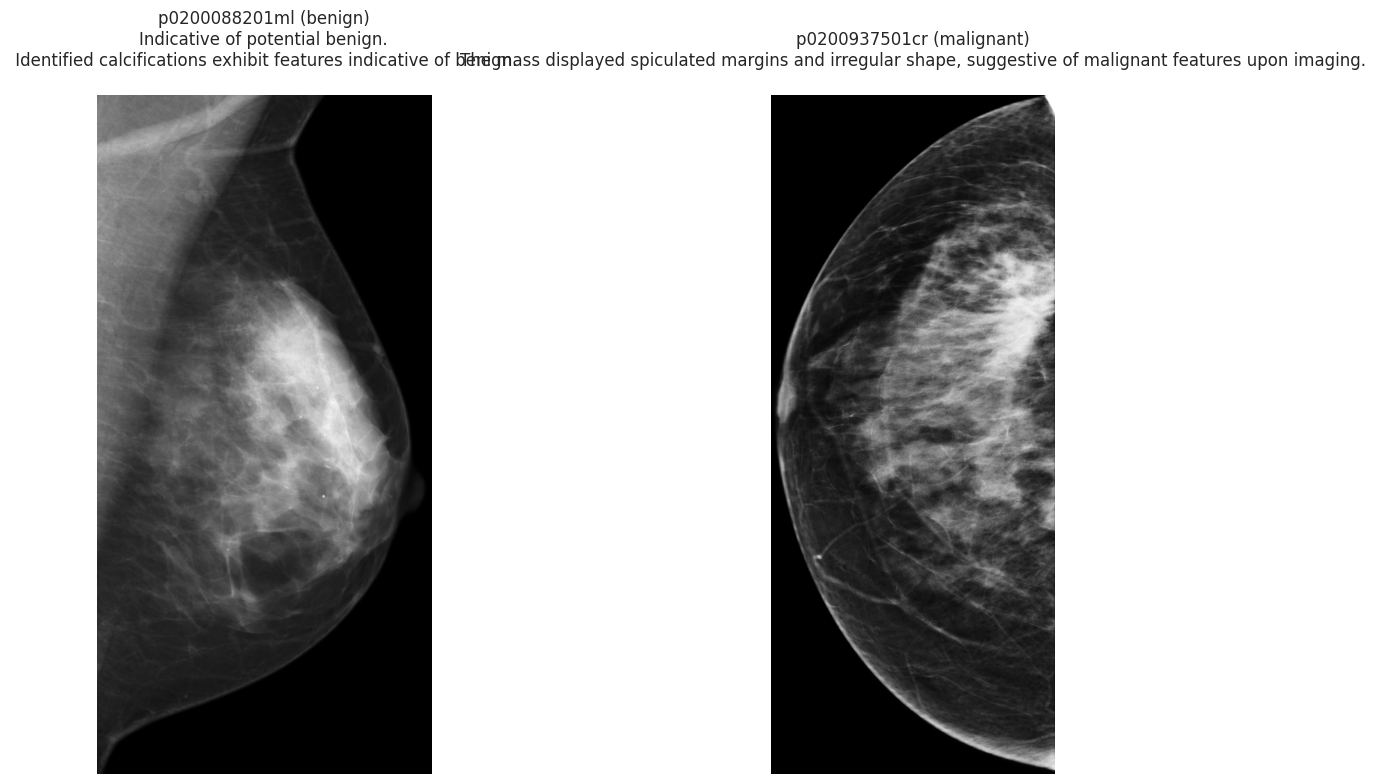

In [16]:
for idx, batch in enumerate(train_dataloader):
    image_features = batch["image_features"]
    text_tokens = batch['text_tokens']
    image_description = batch["image_description"]
    image_label = batch["image_label"]
    image_id = batch["image_id"]
    prompt_labels = batch["prompt_labels"]

    mmgclip.plot_dataloader_batch(batch, base_dataset_path=mmgconfig.dataset.config.base_dataset_path)
    print(prompt_labels)
    print(image_id)
    print(image_description)
    
    break
    

In [27]:
dd = [{'HasMassLabels': 1, 'MassShapeLabels': 'unknown', 'MassMarginLabels': 'unknown', 'BenignMalignantDatasetLabels': 'benign'}, {'HasMassLabels': 1, 'MassShapeLabels': 'oval', 'MassMarginLabels': 'illdefined', 'BenignMalignantDatasetLabels': 'benign'}]

y_true = [[label['BenignMalignantDatasetLabels']] for label in dd]
y_true

[['benign'], ['benign']]

In [16]:
image_features[0].shape

torch.Size([3, 224, 224])

In [22]:
import copy
import matplotlib.pyplot as plt

def denormalize(array, mean, std):
    """
    Denormalize a NumPy array by reversing the normalization process.

    Args:
        array (numpy.ndarray): Input array.
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.

    Returns:
        numpy.ndarray: Denormalized array.
    """
    # Copy the array to avoid modifying the original
    denormalized_array = copy.deepcopy(array)
    
    for i in range(len(mean)):
        denormalized_array[..., i] = denormalized_array[..., i] * std[i] + mean[i]
    
    return denormalized_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


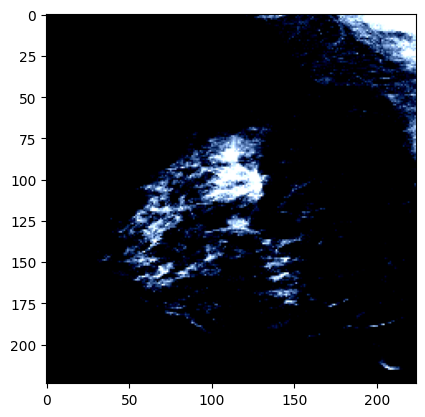

In [33]:
image = np.transpose(image_features[0], (1,2,0))
# image = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

plt.imshow(image) # cmap='gray'

In [14]:
display(image_features)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -0.1828, -0.2684, -0.1657],
          [-2.1179, -2.1179, -2.1179,  ..., -0.3027, -0.3198, -0.3198],
          [-2.1179, -2.1179, -2.1179,  ..., -0.3883, -0.2856, -0.2171],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -1.9467, -1.9809, -2.0152],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9980, -2.0152, -2.0152],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9980, -2.0152, -2.0323]],

         [[-2.0357, -2.0357, -2.0357,  ..., -0.0574, -0.1450, -0.0399],
          [-2.0357, -2.0357, -2.0357,  ..., -0.1800, -0.1975, -0.1975],
          [-2.0357, -2.0357, -2.0357,  ..., -0.2675, -0.1625, -0.0924],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.8606, -1.8957, -1.9307],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9132, -1.9307, -1.9307],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9132, -1.9307, -1.9482]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.1651,  0.0779,  0.1825],
          [-1.8044, -1.8044, -

In [11]:
text_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
text_tokens['attention_mask']

tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:
# similar image descriptions have similar token input ids
# 64 is the batch size, 256 is the max lengh of text set in the tokenizer
print(text_tokens.input_ids.shape)
text_tokens.input_ids

torch.Size([2, 256])


tensor([[  101, 26771,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [14]:
text_tokens

{'input_ids': tensor([[  101, 26771,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [15]:
print(image_features[0].max(), image_features[0].min())
print(image_features.device)

tensor(2.6704) tensor(0.3801)
cpu


In [16]:
eos_token_indices = text_tokens['attention_mask']
eos_token_indices.shape

torch.Size([2, 256])

In [17]:
train_dataloader_sampled = torch.utils.data.DataLoader(
    train_clf_split, 
    sampler=ImbalancedDatasetSampler(train_clf_split, class_name='image_description'),
    batch_size= 8,#128, #256,
    drop_last=True,
    pin_memory= False,#True,
    num_workers=8,
    prefetch_factor=16,
    collate_fn=clf_dataset.collate_fn)


INFO	 | Using a sampler for handling class imbalance.


In [18]:
train_dataloader_sampled.batch_size

8

len: 8
['undefined', 'illdefined', 'obscured', 'spiculated', 'circumscribed', 'undefined', 'illdefined', 'obscured']
image_id:  ['p0200274503cl', 'p0200395001mr', 'p0200109502mr', 'p0200340601cl', 'p0200129702ml', 'p0200135204ml', 'p0200286201ml', 'p0200594001cl'] 



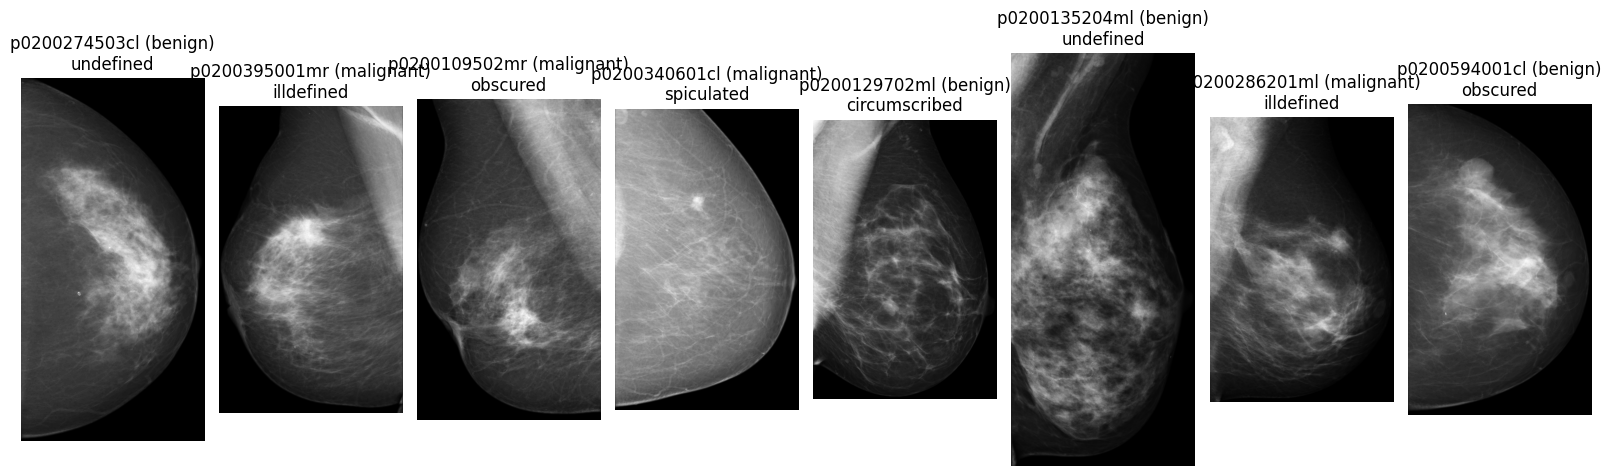

In [19]:
contains_mass_names = []
no_mass_names = []

for idx, batch in enumerate(train_dataloader_sampled):
    image_features = batch["image_features"]
    text_tokens = batch['text_tokens']
    image_description = batch["image_description"]
    image_label = batch["image_label"]
    image_id = batch["image_id"]

    mmgclip.plot_dataloader_batch(batch)
    print("len:", len(batch['image_features']))

    # print(image_features.shape)
    # print(len(text_tokens))
    print(image_description)
    # print("image_label.shape: ", image_label.shape, " image_label", image_label)
    print("image_id: ", image_id, '\n')

    contains_mass_names.append(image_id[0])
    no_mass_names.append(image_id[1])

    break

In [20]:
print(len(contains_mass_names), len(np.unique(contains_mass_names)), contains_mass_names)
print(len(no_mass_names), len(np.unique(no_mass_names)), no_mass_names)

1 1 ['p0200274503cl']
1 1 ['p0200395001mr']
